
# Taks 1: Data scraping

The codes for Task 1:

**XJTLU**<br>
**Name:** Changqing Lin <br>
**ID:** 2039153 <br>

In [1]:
import re
import time
import random
# Python built-in library for comparing objects (str in this project)
import difflib
import requests
import numpy as np
# Library for parsing the search query to standardized format required by a url
import urllib.parse
import pandas as pd
from tqdm import tqdm  # Library to make progress bars
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from datetime import datetime
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import urllib3
urllib3.disable_warnings()
from time import sleep
import ast
from collections import Counter
from itertools import combinations

In [2]:
def get_page_soups():
    """Iteratively scrape the web to get the access (urls) to all 100 quots"""
    base_url = 'http://quotes.toscrape.com/'
    for i in range(1,11):
        url = f'{base_url}/page/{i}/'
        # Books To Scrape do not have an anti-crawlers mechanism, so we do not need to use headers, cookies, etc.
        result = requests.get(url)
        # Use UTF-8 encoding to decode the webpage to avoid garbled code problem
        result.encoding = 'utf-8'
        # Parse the html with BeautifulSoup
        soup = BeautifulSoup(result.text, 'html.parser')
        yield soup


In [15]:
def get_quote_details(soup):
    """Get details of quotes from the provided URL"""
    time.sleep(0.5 * random.random())
    quotes_data = []
    base_url = 'http://quotes.toscrape.com'
    quotes = soup.find_all("div", class_="quote")
    for quote in quotes:
        content = quote.find('span', class_='text').text.strip()
        tags = [tag.text for tag in quote.find_all('a', class_="tag")]
        author_url = base_url + quote.find('a')['href']

        # Extract author details
        author_details = get_author_details(author_url)

        # Split the author's name into two parts
        first_name, last_name = author_details['Author'].split(' ', 1)
        
        # Construct the Goodreads URL using the author's name
        author_search_url = f'https://www.goodreads.com/search?utf8=%E2%9C%93&q={first_name}+{last_name}&search_type=quotes'
        
        quote_data = {
            'Quote Content': content,
            'Tags': tags,
            'Author': author_details['Author'],
            'Birthday of the author': author_details['Birthday'],
            'Country of the author': author_details['Country'],
            'Description of the author': author_details['Description']
        }
        quotes_data.append(quote_data)
        
    return pd.DataFrame(quotes_data)

def get_author_details(url):
    """Get the details of the author from the provided URL"""
    result = requests.get(url)
    result.encoding = 'utf-8'
    soup = BeautifulSoup(result.text, 'html.parser')
    
    # Extracting Author's Name
    author_name = soup.find('h3', class_='author-title').text.strip()
    
    # Extracting Author's Birth Date
    birth_date = soup.find('span', class_='author-born-date').text.strip()
    
    # Extracting Author's Country (or Location)
    location = soup.find('span', class_='author-born-location').text.strip()
    
    # Since the location starts with 'in', we're removing that part
    country = location[3:]
    
    # Extracting Author's Description
    description = soup.find('div', class_='author-description').text.strip()
    
    return {
        'Author': author_name,
        'Birthday': birth_date,
        'Country': country,
        'Description': description
    }


In [16]:
# Function to standardize date format
def standardize_date(date_str):
    try:
        # Attempt to parse the date
        return datetime.strptime(date_str, '%B %d, %Y').strftime('%Y-%m-%d')
    except ValueError:
        # If parsing fails, return the original string
        return date_str

def scrape_quotes():
    quotes_df = pd.DataFrame()
    with tqdm(total=10) as pbar:
        # Set the title of the progress bar
        pbar.set_description('Scraping book details')
        # Initialize a pd.DataFrame of quotes
        for page_soup in get_page_soups():
            quotes_df = pd.concat([quotes_df, get_quote_details(page_soup)],
                                     axis=0, ignore_index=False).reset_index(drop=True)
            quotes_df['Birthday of the author'] = quotes_df['Birthday of the author'].apply(standardize_date)
            pbar.update(1)

    return quotes_df


quotes_df = pd.DataFrame()
quotes_df = scrape_quotes()
quotes_df.to_csv('./quotes_to_scrape.csv', index=False, encoding="utf_8_sig")
quotes_df.head()

Scraping book details: 100%|██████████| 10/10 [04:01<00:00, 24.16s/it]


,Quote Content,Tags,Author,Birthday of the author,Country of the author,Description of the author
0,“The world as we have created it is a process ...,"[change, deep-thoughts, thinking, world]",Albert Einstein,1879-03-14,"Ulm, Germany","In 1879, Albert Einstein was born in Ulm, Germ..."
1,"“It is our choices, Harry, that show what we t...","[abilities, choices]",J.K. Rowling,1965-07-31,"Yate, South Gloucestershire, England, The Unit...",See also: Robert GalbraithAlthough she writes ...
2,“There are only two ways to live your life. On...,"[inspirational, life, live, miracle, miracles]",Albert Einstein,1879-03-14,"Ulm, Germany","In 1879, Albert Einstein was born in Ulm, Germ..."
3,"“The person, be it gentleman or lady, who has ...","[aliteracy, books, classic, humor]",Jane Austen,1775-12-16,"Steventon Rectory, Hampshire, The United Kingdom",Jane Austen was an English novelist whose work...
4,"“Imperfection is beauty, madness is genius and...","[be-yourself, inspirational]",Marilyn Monroe,1926-06-01,The United States,Marilyn Monroe (born Norma Jeane Mortenson; Ju...


# Data with more properties

#### Description of method
Sourced from Wikipedia: "[Goodreads](https://www.goodreads.com/)" is a social networking site centered around book sharing. It provides users with the ability to search for book titles, synopses, and reviews that users have submitted to the platform. The site is not just for bibliographies; it also hosts an extensive collection of literary quotes, many of which are featured on [Quotes To Scrape](http://quotes.toscrape.com/) and sourced from Goodreads. Consequently, we can determine the number of followers for each quote author on this site.

To begin scraping the desired content, one must first access the target website. It is imperative to acquire a link to the Goodreads page that lists information about the authors cited on [Quotes To Scrape](http://quotes.toscrape.com/), which necessitates being logged into the site. An examination of the site's **login** mechanism revealed that it entails utilizing a `csrf_token`, inputting a **random username and password**, and then submitting these details via a **POST request** within the same session to uncover otherwise concealed links. By preserving the logged-in status within the session and focusing on the correct elements, we can gather a comprehensive list of links to the authors' profiles.

After various experiments and adjustments to the redirection approach, I secured connections with two distinct Goodreads URLs to ensure a controlled and transparent scraping process. The URL <https://www.goodreads.com/search?utf8=✓&q=Albert+Einstein&search_type=quotes> was employed specifically to validate a stable connection to the Goodreads server, a task complicated by recurring SSLEOF Errors. A successful link to this trial page is vital before continuing to harvest the compilation of authors' links.

To bypass potential scraping defenses, implementing **headers** and **strategic pauses (randomized sleep)** is advisable.

When navigating to the designated URLs from the assembled list of authors' links, an `h2` segment containing the target data is generally identifiable. Utilizing BeautifulSoup, this information can be effortlessly extracted.

The range in the number of tags linked to each quote might indicate the diverse methodologies authors use in tagging their quotes. Moreover, quotes adorned with a wider selection of tags may have a greater propensity to feature in assorted tag groupings, thereby enhancing the author's visibility and, indirectly, their follower count.


In [4]:
# Create a session object
session = requests.Session()

# Get CSRF token
login_url = "http://quotes.toscrape.com/login"
response = session.get(login_url)
soup = BeautifulSoup(response.content, 'lxml')
csrf_token = soup.find('input', {'name': 'csrf_token'})['value']

# Login using the CSRF token
login_data = {
    'csrf_token': csrf_token,
    'username': '123',   
    'password': '123'    
}

response = session.post(login_url, data=login_data)

# Print the response to check
print(response.text[:1000])
print(response.url)

new_logined_base_url = response.url

def get_login_page():
    for i in range (1,11):
        url = f'{new_logined_base_url}/page/{i}/'
        # Books To Scrape do not have an anti-crawlers mechanism, so we do not need to use headers, cookies, etc.
        result = session.get(url)
        # Use UTF-8 encoding to decode the webpage to avoid garbled code problem
        result.encoding = 'utf-8'
        # Parse the html with BeautifulSoup
        new_soup = BeautifulSoup(result.text, 'html.parser')
        yield new_soup

# Get the author link for each quote
quotes_page = session.get('http://quotes.toscrape.com/')
soup = BeautifulSoup(response.content, 'lxml')

author_links = []
for logined_page_soup in get_login_page():
    print(logined_page_soup.text[:1000])
    quotes = logined_page_soup.find_all("div", class_="quote")
    for quote in quotes:
        span = quote.find_all('span')[-1]
        span_text = span.text.strip()
        author_url =(span.find_all('a')[-1])['href']
        print(author_url)
        author_links.append(author_url)      


<!DOCTYPE html>
<html lang="en">
<head>
	<meta charset="UTF-8">
	<title>Quotes to Scrape</title>
    <link rel="stylesheet" href="/static/bootstrap.min.css">
    <link rel="stylesheet" href="/static/main.css">
</head>
<body>
    <div class="container">
        <div class="row header-box">
            <div class="col-md-8">
                <h1>
                    <a href="/" style="text-decoration: none">Quotes to Scrape</a>
                </h1>
            </div>
            <div class="col-md-4">
                <p>
                
                    <a href="/logout">Logout</a>
                
                </p>
            </div>
        </div>
    

<div class="row">
    <div class="col-md-8">

    <div class="quote" itemscope itemtype="http://schema.org/CreativeWork">
        <span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
        <span>by <small class="author" item





Quotes to Scrape








Quotes to Scrape




Logout






“There is nothing I would not do for those who are really my friends. I have no notion of loving people by halves, it is not my nature.”
by Jane Austen
(about) - (Goodreads page)


            Tags:
            
friendship
love



“Do one thing every day that scares you.”
by Eleanor Roosevelt
(about) - (Goodreads page)


            Tags:
            
attributed
fear
inspiration



“I am good, but not an angel. I do sin, but I am not the devil. I am just a small girl in a big world trying to find someone to love.”
by Marilyn Monroe
(about) - (Goodreads page)


            Tags:
            
attributed-no-source



“If I were not a physicist, I would probably be a musician. I often think in music. I live my daydreams in music. I see my life in terms of music.”
by Albert Einstein
(about) - (Goodreads page)


            Tags:
            
music



“If you only read the books that everyone else is reading, you can only think w

In [5]:
## Create an empty DataFrame
df = pd.DataFrame(columns=['Author', 'Followers'])

base_url = 'https://www.goodreads.com'

# Initiate an HTTP request to get the content of the test connection page
connection_testing_url = base_url + '/search?utf8=✓&q=Albert+Einstein&search_type=quotes'
print('url_type: ', type(connection_testing_url))

head = [
    {
        'user-agent': 'Mozilla/5.0 (iPhone; CPU iPhone OS 13_2_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.3 Mobile/15E148 Safari/604.1'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 8.0.0; SM-G955U Build/R16NW) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 10; SM-G981B) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.162 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (iPad; CPU OS 13_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) CriOS/87.0.4280.77 Mobile/15E148 Safari/604.1'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 8.0; Pixel 2 Build/OPD3.170816.012) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.109 Safari/537.36 CrKey/1.54.248666'
    }, {
        'user-agent': 'Mozilla/5.0 (X11; Linux aarch64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.188 Safari/537.36 CrKey/1.54.250320'
    }, {
        'user-agent': 'Mozilla/5.0 (BB10; Touch) AppleWebKit/537.10+ (KHTML, like Gecko) Version/10.0.9.2372 Mobile Safari/537.10+'
    }, {
        'user-agent': 'Mozilla/5.0 (PlayBook; U; RIM Tablet OS 2.1.0; en-US) AppleWebKit/536.2+ (KHTML like Gecko) Version/7.2.1.0 Safari/536.2+'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; U; Android 4.3; en-us; SM-N900T Build/JSS15J) AppleWebKit/534.30 (KHTML, like Gecko) Version/4.0 Mobile Safari/534.30'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; U; Android 4.1; en-us; GT-N7100 Build/JRO03C) AppleWebKit/534.30 (KHTML, like Gecko) Version/4.0 Mobile Safari/534.30'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; U; Android 4.0; en-us; GT-I9300 Build/IMM76D) AppleWebKit/534.30 (KHTML, like Gecko) Version/4.0 Mobile Safari/534.30'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 7.0; SM-G950U Build/NRD90M) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.84 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 8.0.0; SM-G965U Build/R16NW) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.111 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 8.1.0; SM-T837A) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.80 Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; U; en-us; KFAPWI Build/JDQ39) AppleWebKit/535.19 (KHTML, like Gecko) Silk/3.13 Safari/535.19 Silk-Accelerated=true'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; U; Android 4.4.2; en-us; LGMS323 Build/KOT49I.MS32310c) AppleWebKit/537.36 (KHTML, like Gecko) Version/4.0 Chrome/102.0.0.0 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Windows Phone 10.0; Android 4.2.1; Microsoft; Lumia 550) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/46.0.2486.0 Mobile Safari/537.36 Edge/14.14263'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 6.0.1; Moto G (4)) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 6.0.1; Nexus 10 Build/MOB31T) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 4.4.2; Nexus 4 Build/KOT49H) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 8.0.0; Nexus 5X Build/OPR4.170623.006) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 7.1.1; Nexus 6 Build/N6F26U) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 8.0.0; Nexus 6P Build/OPP3.170518.006) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 6.0.1; Nexus 7 Build/MOB30X) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (compatible; MSIE 10.0; Windows Phone 8.0; Trident/6.0; IEMobile/10.0; ARM; Touch; NOKIA; Lumia 520)'
    }, {
        'user-agent': 'Mozilla/5.0 (MeeGo; NokiaN9) AppleWebKit/534.13 (KHTML, like Gecko) NokiaBrowser/8.5.0 Mobile Safari/534.13'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 9; Pixel 3 Build/PQ1A.181105.017.A1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 10; Pixel 4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 11; Pixel 3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.181 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 5.0; SM-G900P Build/LRX21T) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 8.0; Pixel 2 Build/OPD3.170816.012) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (Linux; Android 8.0.0; Pixel 2 XL Build/OPD1.170816.004) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Mobile Safari/537.36'
    }, {
        'user-agent': 'Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_1 like Mac OS X) AppleWebKit/603.1.30 (KHTML, like Gecko) Version/10.0 Mobile/14E304 Safari/602.1'
    }, {
        'user-agent': 'Mozilla/5.0 (iPhone; CPU iPhone OS 13_2_3 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.3 Mobile/15E148 Safari/604.1'
    }, {
        'user-agent': 'Mozilla/5.0 (iPad; CPU OS 11_0 like Mac OS X) AppleWebKit/604.1.34 (KHTML, like Gecko) Version/11.0 Mobile/15A5341f Safari/604.1'
    }
]

headers = random.choice(head)

session = requests.session()
try:
	response = session.get(connection_testing_url, headers=headers, verify=False)
except:
	response = session.get(connection_testing_url, headers=headers, verify=False)

# The 200 server processed the request successfully
if response.status_code == 200:
    print("You have connected to the Goodreads Testing Page")
    soup = BeautifulSoup(response.text, 'html.parser')
    print('''The content of this page:
    ''' + response.text[:284])
    for author_link in author_links:
        print(author_link)
        author_response = requests.get(author_link, headers=headers)
        if author_response.status_code == 200:
            print("You have enter the page of " + str(author_link))
            author_soup = BeautifulSoup(author_response.text, 'html.parser')
            author_name = author_soup.find('span', class_='authorOrTitle').text.strip()
            followers = author_soup.find('h2', class_='brownBackground').text.strip()
            df = df.append({'Author': author_name, 'Followers': followers},
                       ignore_index=True)
            print("Current df is: " + df)
            sleep(30)  # Add delays to reduce the frequency of requests
        else:
            print(f"Unable to get author page: {author_url}")
        
        df.to_csv('goodreads_quotes_followers_rating.csv', encoding = 'utf-8-sig', index=False)
    print("The data has been saved to goodreads_quotes_followers_rating.csv")
else:
    print("Unable to get page content")


url_type:  <class 'str'>
You have connected to the Goodreads Testing Page
The content of this page:
    <!DOCTYPE html>
<html class="desktop withSiteHeaderTopFullImage
">
<head>
  <title>Search results for &quot;Albert Einstein&quot; (showing 1-20 of 2680 quotes)</title>

<meta content='Search results for Albert Einstein: , , , , , , , , , , , , , , , , , , , and ' name='description'>

http://goodreads.com/author/show/9810.Albert_Einstein
You have enter the page of http://goodreads.com/author/show/9810.Albert_Einstein
                           Author  \
0  Current df is: Albert Einstein   

                                           Followers  
0  Current df is: Albert Einstein’s Followers (9,...  
http://goodreads.com/author/show/1077326.J_K_Rowling
You have enter the page of http://goodreads.com/author/show/1077326.J_K_Rowling
                           Author  \
0  Current df is: Albert Einstein   
1    Current df is: J.K. Rowling,   

                                           Fol

http://goodreads.com/author/show/1077326.J_K_Rowling
You have enter the page of http://goodreads.com/author/show/1077326.J_K_Rowling
                              Author  \
0     Current df is: Albert Einstein   
1       Current df is: J.K. Rowling,   
2     Current df is: Albert Einstein   
3        Current df is: Jane Austen,   
4      Current df is: Marilyn Monroe   
5     Current df is: Albert Einstein   
6         Current df is: Andre Gide,   
7    Current df is: Thomas A. Edison   
8   Current df is: Eleanor Roosevelt   
9        Current df is: Steve Martin   
10     Current df is: Marilyn Monroe   
11      Current df is: J.K. Rowling,   

                                            Followers  
0   Current df is: Albert Einstein’s Followers (9,...  
1   Current df is: J.K. Rowling’s Followers (223,078)  
2   Current df is: Albert Einstein’s Followers (9,...  
3     Current df is: Jane Austen’s Followers (64,469)  
4   Current df is: Marilyn Monroe’s Followers (6,253)  
5   Curren

http://goodreads.com/author/show/1938.Friedrich_Nietzsche
You have enter the page of http://goodreads.com/author/show/1938.Friedrich_Nietzsche
                                 Author  \
0        Current df is: Albert Einstein   
1          Current df is: J.K. Rowling,   
2        Current df is: Albert Einstein   
3           Current df is: Jane Austen,   
4         Current df is: Marilyn Monroe   
5        Current df is: Albert Einstein   
6            Current df is: Andre Gide,   
7       Current df is: Thomas A. Edison   
8      Current df is: Eleanor Roosevelt   
9           Current df is: Steve Martin   
10        Current df is: Marilyn Monroe   
11         Current df is: J.K. Rowling,   
12       Current df is: Albert Einstein   
13            Current df is: Bob Marley   
14             Current df is: Dr. Seuss   
15        Current df is: douglas adams,   
16           Current df is: Elie Wiesel   
17  Current df is: Friedrich Nietzsche,   

                                       

http://goodreads.com/author/show/12080.Ralph_Waldo_Emerson
You have enter the page of http://goodreads.com/author/show/12080.Ralph_Waldo_Emerson
                                 Author  \
0        Current df is: Albert Einstein   
1          Current df is: J.K. Rowling,   
2        Current df is: Albert Einstein   
3           Current df is: Jane Austen,   
4         Current df is: Marilyn Monroe   
5        Current df is: Albert Einstein   
6            Current df is: Andre Gide,   
7       Current df is: Thomas A. Edison   
8      Current df is: Eleanor Roosevelt   
9           Current df is: Steve Martin   
10        Current df is: Marilyn Monroe   
11         Current df is: J.K. Rowling,   
12       Current df is: Albert Einstein   
13            Current df is: Bob Marley   
14             Current df is: Dr. Seuss   
15        Current df is: douglas adams,   
16           Current df is: Elie Wiesel   
17  Current df is: Friedrich Nietzsche,   
18            Current df is: Mark Twai

http://goodreads.com/author/show/61105.Dr_Seuss
You have enter the page of http://goodreads.com/author/show/61105.Dr_Seuss
                                 Author  \
0        Current df is: Albert Einstein   
1          Current df is: J.K. Rowling,   
2        Current df is: Albert Einstein   
3           Current df is: Jane Austen,   
4         Current df is: Marilyn Monroe   
5        Current df is: Albert Einstein   
6            Current df is: Andre Gide,   
7       Current df is: Thomas A. Edison   
8      Current df is: Eleanor Roosevelt   
9           Current df is: Steve Martin   
10        Current df is: Marilyn Monroe   
11         Current df is: J.K. Rowling,   
12       Current df is: Albert Einstein   
13            Current df is: Bob Marley   
14             Current df is: Dr. Seuss   
15        Current df is: douglas adams,   
16           Current df is: Elie Wiesel   
17  Current df is: Friedrich Nietzsche,   
18            Current df is: Mark Twain   
19        Current

http://goodreads.com/author/show/9810.Albert_Einstein
You have enter the page of http://goodreads.com/author/show/9810.Albert_Einstein
                                 Author  \
0        Current df is: Albert Einstein   
1          Current df is: J.K. Rowling,   
2        Current df is: Albert Einstein   
3           Current df is: Jane Austen,   
4         Current df is: Marilyn Monroe   
5        Current df is: Albert Einstein   
6            Current df is: Andre Gide,   
7       Current df is: Thomas A. Edison   
8      Current df is: Eleanor Roosevelt   
9           Current df is: Steve Martin   
10        Current df is: Marilyn Monroe   
11         Current df is: J.K. Rowling,   
12       Current df is: Albert Einstein   
13            Current df is: Bob Marley   
14             Current df is: Dr. Seuss   
15        Current df is: douglas adams,   
16           Current df is: Elie Wiesel   
17  Current df is: Friedrich Nietzsche,   
18            Current df is: Mark Twain   
19   

http://goodreads.com/author/show/1077326.J_K_Rowling
You have enter the page of http://goodreads.com/author/show/1077326.J_K_Rowling
                                 Author  \
0        Current df is: Albert Einstein   
1          Current df is: J.K. Rowling,   
2        Current df is: Albert Einstein   
3           Current df is: Jane Austen,   
4         Current df is: Marilyn Monroe   
5        Current df is: Albert Einstein   
6            Current df is: Andre Gide,   
7       Current df is: Thomas A. Edison   
8      Current df is: Eleanor Roosevelt   
9           Current df is: Steve Martin   
10        Current df is: Marilyn Monroe   
11         Current df is: J.K. Rowling,   
12       Current df is: Albert Einstein   
13            Current df is: Bob Marley   
14             Current df is: Dr. Seuss   
15        Current df is: douglas adams,   
16           Current df is: Elie Wiesel   
17  Current df is: Friedrich Nietzsche,   
18            Current df is: Mark Twain   
19     

http://goodreads.com/author/show/1077326.J_K_Rowling
You have enter the page of http://goodreads.com/author/show/1077326.J_K_Rowling
                                 Author  \
0        Current df is: Albert Einstein   
1          Current df is: J.K. Rowling,   
2        Current df is: Albert Einstein   
3           Current df is: Jane Austen,   
4         Current df is: Marilyn Monroe   
5        Current df is: Albert Einstein   
6            Current df is: Andre Gide,   
7       Current df is: Thomas A. Edison   
8      Current df is: Eleanor Roosevelt   
9           Current df is: Steve Martin   
10        Current df is: Marilyn Monroe   
11         Current df is: J.K. Rowling,   
12       Current df is: Albert Einstein   
13            Current df is: Bob Marley   
14             Current df is: Dr. Seuss   
15        Current df is: douglas adams,   
16           Current df is: Elie Wiesel   
17  Current df is: Friedrich Nietzsche,   
18            Current df is: Mark Twain   
19     

http://goodreads.com/author/show/9810.Albert_Einstein
You have enter the page of http://goodreads.com/author/show/9810.Albert_Einstein
                                 Author  \
0        Current df is: Albert Einstein   
1          Current df is: J.K. Rowling,   
2        Current df is: Albert Einstein   
3           Current df is: Jane Austen,   
4         Current df is: Marilyn Monroe   
5        Current df is: Albert Einstein   
6            Current df is: Andre Gide,   
7       Current df is: Thomas A. Edison   
8      Current df is: Eleanor Roosevelt   
9           Current df is: Steve Martin   
10        Current df is: Marilyn Monroe   
11         Current df is: J.K. Rowling,   
12       Current df is: Albert Einstein   
13            Current df is: Bob Marley   
14             Current df is: Dr. Seuss   
15        Current df is: douglas adams,   
16           Current df is: Elie Wiesel   
17  Current df is: Friedrich Nietzsche,   
18            Current df is: Mark Twain   
19   

http://goodreads.com/author/show/346732.George_R_R_Martin
You have enter the page of http://goodreads.com/author/show/346732.George_R_R_Martin
                                 Author  \
0        Current df is: Albert Einstein   
1          Current df is: J.K. Rowling,   
2        Current df is: Albert Einstein   
3           Current df is: Jane Austen,   
4         Current df is: Marilyn Monroe   
5        Current df is: Albert Einstein   
6            Current df is: Andre Gide,   
7       Current df is: Thomas A. Edison   
8      Current df is: Eleanor Roosevelt   
9           Current df is: Steve Martin   
10        Current df is: Marilyn Monroe   
11         Current df is: J.K. Rowling,   
12       Current df is: Albert Einstein   
13            Current df is: Bob Marley   
14             Current df is: Dr. Seuss   
15        Current df is: douglas adams,   
16           Current df is: Elie Wiesel   
17  Current df is: Friedrich Nietzsche,   
18            Current df is: Mark Twain 

http://goodreads.com/author/show/82952.Marilyn_Monroe
You have enter the page of http://goodreads.com/author/show/82952.Marilyn_Monroe
                                 Author  \
0        Current df is: Albert Einstein   
1          Current df is: J.K. Rowling,   
2        Current df is: Albert Einstein   
3           Current df is: Jane Austen,   
4         Current df is: Marilyn Monroe   
5        Current df is: Albert Einstein   
6            Current df is: Andre Gide,   
7       Current df is: Thomas A. Edison   
8      Current df is: Eleanor Roosevelt   
9           Current df is: Steve Martin   
10        Current df is: Marilyn Monroe   
11         Current df is: J.K. Rowling,   
12       Current df is: Albert Einstein   
13            Current df is: Bob Marley   
14             Current df is: Dr. Seuss   
15        Current df is: douglas adams,   
16           Current df is: Elie Wiesel   
17  Current df is: Friedrich Nietzsche,   
18            Current df is: Mark Twain   
19   

http://goodreads.com/author/show/9810.Albert_Einstein
You have enter the page of http://goodreads.com/author/show/9810.Albert_Einstein
                                 Author  \
0        Current df is: Albert Einstein   
1          Current df is: J.K. Rowling,   
2        Current df is: Albert Einstein   
3           Current df is: Jane Austen,   
4         Current df is: Marilyn Monroe   
5        Current df is: Albert Einstein   
6            Current df is: Andre Gide,   
7       Current df is: Thomas A. Edison   
8      Current df is: Eleanor Roosevelt   
9           Current df is: Steve Martin   
10        Current df is: Marilyn Monroe   
11         Current df is: J.K. Rowling,   
12       Current df is: Albert Einstein   
13            Current df is: Bob Marley   
14             Current df is: Dr. Seuss   
15        Current df is: douglas adams,   
16           Current df is: Elie Wiesel   
17  Current df is: Friedrich Nietzsche,   
18            Current df is: Mark Twain   
19   

http://goodreads.com/author/show/82952.Marilyn_Monroe
You have enter the page of http://goodreads.com/author/show/82952.Marilyn_Monroe
                                 Author  \
0        Current df is: Albert Einstein   
1          Current df is: J.K. Rowling,   
2        Current df is: Albert Einstein   
3           Current df is: Jane Austen,   
4         Current df is: Marilyn Monroe   
5        Current df is: Albert Einstein   
6            Current df is: Andre Gide,   
7       Current df is: Thomas A. Edison   
8      Current df is: Eleanor Roosevelt   
9           Current df is: Steve Martin   
10        Current df is: Marilyn Monroe   
11         Current df is: J.K. Rowling,   
12       Current df is: Albert Einstein   
13            Current df is: Bob Marley   
14             Current df is: Dr. Seuss   
15        Current df is: douglas adams,   
16           Current df is: Elie Wiesel   
17  Current df is: Friedrich Nietzsche,   
18            Current df is: Mark Twain   
19   

http://goodreads.com/author/show/1077326.J_K_Rowling
You have enter the page of http://goodreads.com/author/show/1077326.J_K_Rowling
                                    Author  \
0           Current df is: Albert Einstein   
1             Current df is: J.K. Rowling,   
2           Current df is: Albert Einstein   
3              Current df is: Jane Austen,   
4            Current df is: Marilyn Monroe   
5           Current df is: Albert Einstein   
6               Current df is: Andre Gide,   
7          Current df is: Thomas A. Edison   
8         Current df is: Eleanor Roosevelt   
9              Current df is: Steve Martin   
10           Current df is: Marilyn Monroe   
11            Current df is: J.K. Rowling,   
12          Current df is: Albert Einstein   
13               Current df is: Bob Marley   
14                Current df is: Dr. Seuss   
15           Current df is: douglas adams,   
16              Current df is: Elie Wiesel   
17     Current df is: Friedrich Nietzsc

http://goodreads.com/author/show/1265.Jane_Austen
You have enter the page of http://goodreads.com/author/show/1265.Jane_Austen
                                    Author  \
0           Current df is: Albert Einstein   
1             Current df is: J.K. Rowling,   
2           Current df is: Albert Einstein   
3              Current df is: Jane Austen,   
4            Current df is: Marilyn Monroe   
5           Current df is: Albert Einstein   
6               Current df is: Andre Gide,   
7          Current df is: Thomas A. Edison   
8         Current df is: Eleanor Roosevelt   
9              Current df is: Steve Martin   
10           Current df is: Marilyn Monroe   
11            Current df is: J.K. Rowling,   
12          Current df is: Albert Einstein   
13               Current df is: Bob Marley   
14                Current df is: Dr. Seuss   
15           Current df is: douglas adams,   
16              Current df is: Elie Wiesel   
17     Current df is: Friedrich Nietzsche,   

http://goodreads.com/author/show/82952.Marilyn_Monroe
You have enter the page of http://goodreads.com/author/show/82952.Marilyn_Monroe
                                    Author  \
0           Current df is: Albert Einstein   
1             Current df is: J.K. Rowling,   
2           Current df is: Albert Einstein   
3              Current df is: Jane Austen,   
4            Current df is: Marilyn Monroe   
5           Current df is: Albert Einstein   
6               Current df is: Andre Gide,   
7          Current df is: Thomas A. Edison   
8         Current df is: Eleanor Roosevelt   
9              Current df is: Steve Martin   
10           Current df is: Marilyn Monroe   
11            Current df is: J.K. Rowling,   
12          Current df is: Albert Einstein   
13               Current df is: Bob Marley   
14                Current df is: Dr. Seuss   
15           Current df is: douglas adams,   
16              Current df is: Elie Wiesel   
17     Current df is: Friedrich Nietz

http://goodreads.com/author/show/3354.Haruki_Murakami
You have enter the page of http://goodreads.com/author/show/3354.Haruki_Murakami
                                    Author  \
0           Current df is: Albert Einstein   
1             Current df is: J.K. Rowling,   
2           Current df is: Albert Einstein   
3              Current df is: Jane Austen,   
4            Current df is: Marilyn Monroe   
5           Current df is: Albert Einstein   
6               Current df is: Andre Gide,   
7          Current df is: Thomas A. Edison   
8         Current df is: Eleanor Roosevelt   
9              Current df is: Steve Martin   
10           Current df is: Marilyn Monroe   
11            Current df is: J.K. Rowling,   
12          Current df is: Albert Einstein   
13               Current df is: Bob Marley   
14                Current df is: Dr. Seuss   
15           Current df is: douglas adams,   
16              Current df is: Elie Wiesel   
17     Current df is: Friedrich Nietz

http://goodreads.com/author/show/941441.Stephenie_Meyer
You have enter the page of http://goodreads.com/author/show/941441.Stephenie_Meyer
                                    Author  \
0           Current df is: Albert Einstein   
1             Current df is: J.K. Rowling,   
2           Current df is: Albert Einstein   
3              Current df is: Jane Austen,   
4            Current df is: Marilyn Monroe   
5           Current df is: Albert Einstein   
6               Current df is: Andre Gide,   
7          Current df is: Thomas A. Edison   
8         Current df is: Eleanor Roosevelt   
9              Current df is: Steve Martin   
10           Current df is: Marilyn Monroe   
11            Current df is: J.K. Rowling,   
12          Current df is: Albert Einstein   
13               Current df is: Bob Marley   
14                Current df is: Dr. Seuss   
15           Current df is: douglas adams,   
16              Current df is: Elie Wiesel   
17     Current df is: Friedrich N

http://goodreads.com/author/show/7275.Helen_Keller
You have enter the page of http://goodreads.com/author/show/7275.Helen_Keller
                                    Author  \
0           Current df is: Albert Einstein   
1             Current df is: J.K. Rowling,   
2           Current df is: Albert Einstein   
3              Current df is: Jane Austen,   
4            Current df is: Marilyn Monroe   
5           Current df is: Albert Einstein   
6               Current df is: Andre Gide,   
7          Current df is: Thomas A. Edison   
8         Current df is: Eleanor Roosevelt   
9              Current df is: Steve Martin   
10           Current df is: Marilyn Monroe   
11            Current df is: J.K. Rowling,   
12          Current df is: Albert Einstein   
13               Current df is: Bob Marley   
14                Current df is: Dr. Seuss   
15           Current df is: douglas adams,   
16              Current df is: Elie Wiesel   
17     Current df is: Friedrich Nietzsche, 

http://goodreads.com/author/show/13275.Charles_Bukowski
You have enter the page of http://goodreads.com/author/show/13275.Charles_Bukowski
                                Author  \
0       Current df is: Albert Einstein   
1         Current df is: J.K. Rowling,   
2       Current df is: Albert Einstein   
3          Current df is: Jane Austen,   
4        Current df is: Marilyn Monroe   
..                                 ...   
56     Current df is: Stephenie Meyer,   
57     Current df is: Ernest Hemingway   
58         Current df is: Helen Keller   
59  Current df is: George Bernard Shaw   
60     Current df is: Charles Bukowski   

                                            Followers  
0   Current df is: Albert Einstein’s Followers (9,...  
1   Current df is: J.K. Rowling’s Followers (223,078)  
2   Current df is: Albert Einstein’s Followers (9,...  
3     Current df is: Jane Austen’s Followers (64,469)  
4   Current df is: Marilyn Monroe’s Followers (6,253)  
..                  

http://goodreads.com/author/show/12080.Ralph_Waldo_Emerson
You have enter the page of http://goodreads.com/author/show/12080.Ralph_Waldo_Emerson
                                Author  \
0       Current df is: Albert Einstein   
1         Current df is: J.K. Rowling,   
2       Current df is: Albert Einstein   
3          Current df is: Jane Austen,   
4        Current df is: Marilyn Monroe   
..                                 ...   
63          Current df is: C.S. Lewis,   
64      Current df is: J.R.R. Tolkien,   
65        Current df is: J.K. Rowling,   
66     Current df is: Ernest Hemingway   
67  Current df is: Ralph Waldo Emerson   

                                            Followers  
0   Current df is: Albert Einstein’s Followers (9,...  
1   Current df is: J.K. Rowling’s Followers (223,078)  
2   Current df is: Albert Einstein’s Followers (9,...  
3     Current df is: Jane Austen’s Followers (64,469)  
4   Current df is: Marilyn Monroe’s Followers (6,253)  
..            

http://goodreads.com/author/show/819789.J_D_Salinger
You have enter the page of http://goodreads.com/author/show/819789.J_D_Salinger
                             Author  \
0    Current df is: Albert Einstein   
1      Current df is: J.K. Rowling,   
2    Current df is: Albert Einstein   
3       Current df is: Jane Austen,   
4     Current df is: Marilyn Monroe   
..                              ...   
70   Current df is: Alfred Tennyson   
71  Current df is: Charles Bukowski   
72  Current df is: Terry Pratchett,   
73         Current df is: Dr. Seuss   
74    Current df is: J.D. Salinger,   

                                            Followers  
0   Current df is: Albert Einstein’s Followers (9,...  
1   Current df is: J.K. Rowling’s Followers (223,078)  
2   Current df is: Albert Einstein’s Followers (9,...  
3     Current df is: Jane Austen’s Followers (64,469)  
4   Current df is: Marilyn Monroe’s Followers (6,253)  
..                                                ...  
70  Cu

http://goodreads.com/author/show/1265.Jane_Austen
You have enter the page of http://goodreads.com/author/show/1265.Jane_Austen
                            Author  \
0   Current df is: Albert Einstein   
1     Current df is: J.K. Rowling,   
2   Current df is: Albert Einstein   
3      Current df is: Jane Austen,   
4    Current df is: Marilyn Monroe   
..                             ...   
77      Current df is: W.C. Fields   
78        Current df is: Ayn Rand,   
79       Current df is: Mark Twain   
80  Current df is: Albert Einstein   
81     Current df is: Jane Austen,   

                                            Followers  
0   Current df is: Albert Einstein’s Followers (9,...  
1   Current df is: J.K. Rowling’s Followers (223,078)  
2   Current df is: Albert Einstein’s Followers (9,...  
3     Current df is: Jane Austen’s Followers (64,469)  
4   Current df is: Marilyn Monroe’s Followers (6,253)  
..                                                ...  
77       Current df is: 

http://goodreads.com/author/show/1244.Mark_Twain
You have enter the page of http://goodreads.com/author/show/1244.Mark_Twain
                            Author  \
0   Current df is: Albert Einstein   
1     Current df is: J.K. Rowling,   
2   Current df is: Albert Einstein   
3      Current df is: Jane Austen,   
4    Current df is: Marilyn Monroe   
..                             ...   
84     Current df is: Jane Austen,   
85      Current df is: C.S. Lewis,   
86      Current df is: C.S. Lewis,   
87       Current df is: Mark Twain   
88       Current df is: Mark Twain   

                                            Followers  
0   Current df is: Albert Einstein’s Followers (9,...  
1   Current df is: J.K. Rowling’s Followers (223,078)  
2   Current df is: Albert Einstein’s Followers (9,...  
3     Current df is: Jane Austen’s Followers (64,469)  
4   Current df is: Marilyn Monroe’s Followers (6,253)  
..                                                ...  
84    Current df is: Jane 

http://goodreads.com/author/show/1825.Harper_Lee
You have enter the page of http://goodreads.com/author/show/1825.Harper_Lee
                            Author  \
0   Current df is: Albert Einstein   
1     Current df is: J.K. Rowling,   
2   Current df is: Albert Einstein   
3      Current df is: Jane Austen,   
4    Current df is: Marilyn Monroe   
..                             ...   
91    Current df is: Jimi Hendrix,   
92     Current df is: J.M. Barrie,   
93    Current df is: E.E. Cummings   
94  Current df is: Khaled Hosseini   
95      Current df is: Harper Lee,   

                                            Followers  
0   Current df is: Albert Einstein’s Followers (9,...  
1   Current df is: J.K. Rowling’s Followers (223,078)  
2   Current df is: Albert Einstein’s Followers (9,...  
3     Current df is: Jane Austen’s Followers (64,469)  
4   Current df is: Marilyn Monroe’s Followers (6,253)  
..                                                ...  
91      Current df is: Jim

In [54]:
# Load the Changqing_Lin_2039153.csv CSV file
file_path_1 = './quotes_to_scrape.csv'
df1 = pd.read_csv(file_path_1)

# Load the goodreads_quotes_followers_rating.csv CSV file
file_path_2 = './goodreads_quotes_followers_rating.csv'
df2 = pd.read_csv(file_path_2)

# Extracting the number of followers from the 'Followers' column in df2
df2['Followers'] = df2['Followers'].str.extract('(\d+(?:,\d+)?)').replace(',', '', regex=True).astype(int)

# Merging the dataframes on the 'Author' column
df3 = df1.join(df2['Followers'])

df3.to_csv('./Changqing_Lin_2039153.csv', index=False, encoding="utf_8_sig")

# Display the first few rows of the merged dataframe
df3_head = df3.head()
df3_head

,Quote Content,Tags,Author,Birthday of the author,Country of the author,Description of the author,Followers
0,“The world as we have created it is a process ...,"['change', 'deep-thoughts', 'thinking', 'world']",Albert Einstein,1879-03-14,"Ulm, Germany","In 1879, Albert Einstein was born in Ulm, Germ...",9258
1,"“It is our choices, Harry, that show what we t...","['abilities', 'choices']",J.K. Rowling,1965-07-31,"Yate, South Gloucestershire, England, The Unit...",See also: Robert GalbraithAlthough she writes ...,223078
2,“There are only two ways to live your life. On...,"['inspirational', 'life', 'live', 'miracle', '...",Albert Einstein,1879-03-14,"Ulm, Germany","In 1879, Albert Einstein was born in Ulm, Germ...",9258
3,"“The person, be it gentleman or lady, who has ...","['aliteracy', 'books', 'classic', 'humor']",Jane Austen,1775-12-16,"Steventon Rectory, Hampshire, The United Kingdom",Jane Austen was an English novelist whose work...,64469
4,"“Imperfection is beauty, madness is genius and...","['be-yourself', 'inspirational']",Marilyn Monroe,1926-06-01,The United States,Marilyn Monroe (born Norma Jeane Mortenson; Ju...,6253


# Task 2

# Topic: The Influence of Tag Combinations on Quote Authors' Follower Counts

# Introduction

The research question I am exploring is: Does the combination of different tags (combinations containing ≥2 tags are considered) affect the number of followers of the author to whom the quote belongs? To illustrate this research question with an example: Suppose certain popular tags often appear together, indicating overlapping themes (such as "love" and "life"). Does this mean that the authors of quotes associated with these commonly co-occurring tags have more followers than authors whose quotes are associated with combinations of tags that appear less frequently? Initially, we will review the existing dataset, identifying the relevant attributes and samples that pertain to our study. Following this selection, we will delve into deeper analysis, utilizing visualization techniques to better interpret our findings. FInally, we will summarize the insights gathered and provide a conclusion that addresses the posed research question.

### Methods 
To navigate through this inquiry, we must first handling the data at our disposal:

In [2]:
file_path = './Changqing_Lin_2039153.csv'
quotes_df = pd.read_csv(file_path)

quotes_df.head()

,Quote Content,Tags,Author,Birthday of the author,Country of the author,Description of the author,Followers
0,“The world as we have created it is a process ...,"['change', 'deep-thoughts', 'thinking', 'world']",Albert Einstein,1879-03-14,"Ulm, Germany","In 1879, Albert Einstein was born in Ulm, Germ...",9258
1,"“It is our choices, Harry, that show what we t...","['abilities', 'choices']",J.K. Rowling,1965-07-31,"Yate, South Gloucestershire, England, The Unit...",See also: Robert GalbraithAlthough she writes ...,223078
2,“There are only two ways to live your life. On...,"['inspirational', 'life', 'live', 'miracle', '...",Albert Einstein,1879-03-14,"Ulm, Germany","In 1879, Albert Einstein was born in Ulm, Germ...",9258
3,"“The person, be it gentleman or lady, who has ...","['aliteracy', 'books', 'classic', 'humor']",Jane Austen,1775-12-16,"Steventon Rectory, Hampshire, The United Kingdom",Jane Austen was an English novelist whose work...,64469
4,"“Imperfection is beauty, madness is genius and...","['be-yourself', 'inspirational']",Marilyn Monroe,1926-06-01,The United States,Marilyn Monroe (born Norma Jeane Mortenson; Ju...,6253


#### Tag Frequency Analysis
Next, well count the frequency of individual tags and tag combinations. This information is foundational for understanding the commonality of tags and their potential collective impact on follower counts.

In [3]:
# Count the frequency of each individual tag
# Assuming the column storing tags is named 'Tags'
# The tags are likely stored in a string representation of lists; we need to convert them back
quotes_df['Tags'] = quotes_df['Tags'].apply(lambda x: eval(x) if isinstance(x, str) else [])

# Flatten the list of tags and count occurrences
all_tags = [tag for sublist in quotes_df['Tags'] for tag in sublist]
tag_counts = Counter(all_tags)

# Count the frequency of each combination of tags
tag_combinations = Counter()

for tags in quotes_df['Tags']:
    # Create all combinations for the tags in each quote, and count them
    for i in range(2, len(tags)+1):  # Starting from 2 as we want combinations, not single tags
        for combo in combinations(tags, i):
            tag_combinations[combo] += 1

# Convert the counter to a DataFrame for better readability
tag_comb_df = pd.DataFrame(tag_combinations.items(), columns=['Tag Combination', 'Frequency'])
tag_comb_df.head()

,Tag Combination,Frequency
0,"(change, deep-thoughts)",1
1,"(change, thinking)",1
2,"(change, world)",1
3,"(deep-thoughts, thinking)",1
4,"(deep-thoughts, world)",1


#### Tag Combination Frequency
With this, we will have a frequency count for each tag combination, which we can then relate to follower counts.

In [4]:
# Filter combinations of tags with frequency greater than 1
tag_combinations_filtered = {combo: count for combo, count in tag_combinations.items() if count > 1}

# Converts results to DataFrame
tag_comb_df_filtered = pd.DataFrame(tag_combinations_filtered.items(), columns=['Tag Combination', 'Frequency'])
tag_comb_df_filtered.sort_values(by='Frequency', ascending=False, inplace=True)
tag_comb_df_filtered.reset_index(drop=True, inplace=True)

# Display combinations with frequency greater than 1
tag_comb_df_filtered  

,Tag Combination,Frequency
0,"(books, reading)",4
1,"(inspirational, life)",3
2,"(friendship, love)",3
3,"(books, classic)",2
4,"(life, love)",2
5,"(friends, life)",2
6,"(inspirational, love)",2
7,"(books, friends)",2
8,"(life, yourself)",2
9,"(books, library)",2


### Visualize the Data

#### Bar Chart
Let's start by observing the characteristics of the tags, so let's plot this using a bar chart to visualize it first:

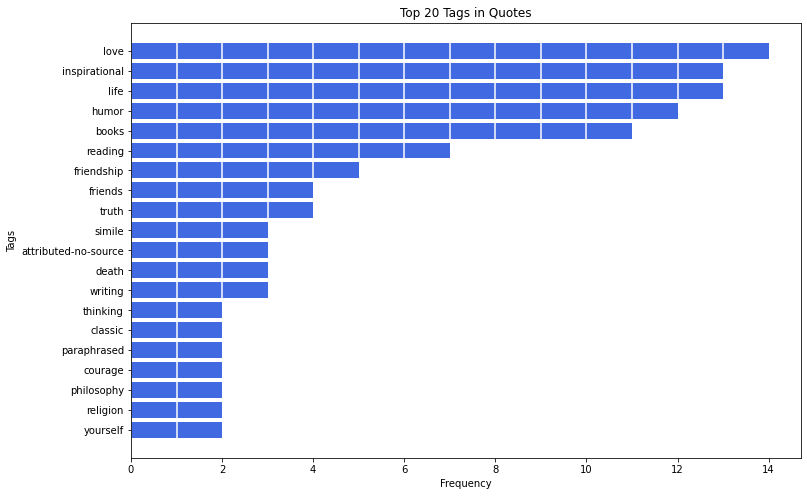

In [5]:
# Suppose tag_counts is a dictionary containing tags and their frequencies
tags, frequencies = zip(*tag_counts.most_common(20))  

# Draw horizontal bar charts through barh
plt.figure(figsize=(12, 8))
bars = plt.barh(tags, frequencies, color='#4169E1')  

for bar in bars:
    height = bar.get_height()
    for y in np.arange(0, bar.get_width(), 1):  
        # Add white bar spacing for each
        plt.plot([y, y], [bar.get_y(), bar.get_y()+height], color='white')

plt.ylabel('Tags')
plt.xlabel('Frequency')
plt.title('Top 20 Tags in Quotes')
# Invert the y-axis so that the highest frequency tags are at the top
plt.gca().invert_yaxis()  
plt.show()


#### Analyze and Pie Chart
The horizontal bar chart displays the top 20 tags in the dataset. The length of each bar represents the frequency of the corresponding tag, with "love," "inspirational," and "life" being the most prevalent. This visualization is critical in understanding which individual tags are most common, and it sets the premise that these tags may play a significant role in the popularity of an author when they appear in combinations.

Next, we should look at the distribution of tag counts in quotes and the distribution of followers to see if there's a visible pattern or trend. Let's continue with the visualization of the distribution of tag counts in quotes.​

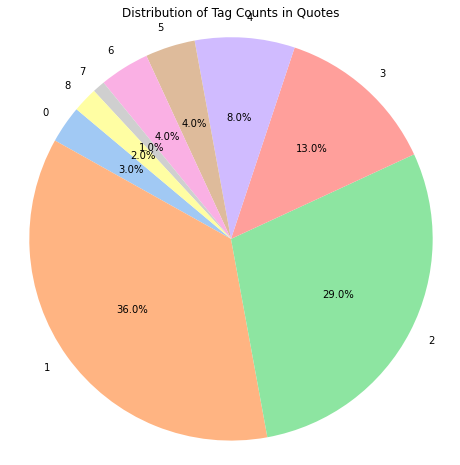

In [6]:
# Count the number of tags for each quote
quotes_df['Tag Count'] = quotes_df['Tags'].apply(len)

# Count the frequency of each tag count
tag_count_freq = quotes_df['Tag Count'].value_counts().sort_index()

# Prepare data for the pie chart
labels = tag_count_freq.index
sizes = tag_count_freq.values
colors = sns.color_palette('pastel')[0:len(labels)]  # Generate as many colors as there are labels

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Tag Counts in Quotes')
plt.show()

#### Analyze and Heat Map
This graph shows the distribution of the number of tags in each citation. Most citations contain between 2 and 5 tags, indicating that tags usually appear in small combinations, which might influence the authors' visibility and indirectly their follower count.The section of the chart that indicates quotes with **two tags**, which accounts for the largest portion **(29%)**, is particularly noteworthy for research. This is because quotes with two tags represent the most common type of tag combination and thus hold the greatest potential for identifying patterns that may correlate with the number of followers an author has. Since these quotes are more likely to appear in various tag-based searches and lists, they may have a broader appeal or resonance with readers, which could translate into a higher number of followers for the authors. 


Based on our analysis of the pie chart, identifying areas with a high degree of overlap may reveal common themes that resonate widely or enjoy popularity. These overlapping themes could potentially attract a larger follower base, a trend that we could further investigate through a **Heat Map**.

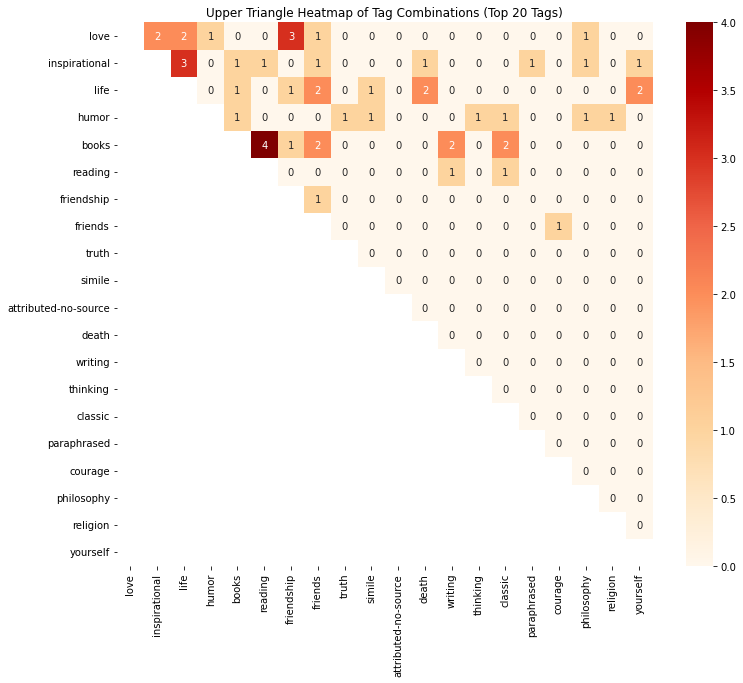

In [8]:
top_tags = [tag for tag, count in tag_counts.most_common(20)]

# Initialize a frequency matrix with zeros
frequency_matrix = pd.DataFrame(0, index=top_tags, columns=top_tags)

# Iterate through the list of tags in the dataframe
for tags in quotes_df['Tags']:
    # Filter the tags to only include the top N tags
    filtered_tags = [tag for tag in tags if tag in top_tags]
    # Update the frequency matrix for each combination of tags
    for tag1, tag2 in combinations(filtered_tags, 2):
        frequency_matrix.loc[tag1, tag2] += 1
        frequency_matrix.loc[tag2, tag1] += 1  # Ensure the matrix is symmetric

# Mask the lower triangle of the matrix this time, including the diagonal
mask = np.tril(np.ones_like(frequency_matrix, dtype=bool))

# Plot the heatmap with the new mask to only show the upper triangle
plt.figure(figsize=(12, 10))
# Use mask to avoid showing the lower triangle
sns.heatmap(frequency_matrix, mask=mask, annot=True, fmt='g', cmap='OrRd')
plt.title(f'Upper Triangle Heatmap of Tag Combinations (Top {20} Tags)')
plt.show()

#### Analyze and Histogram & Boxplot
Here is the upper triangle heatmap displaying the frequency of tag combinations for the top 20 tags. This visualization is particularly useful for identifying which tags are most frequently used together, providing insights into potential correlations between tag combinations and the popularity of an author, as indicated by their follower count.

Moving forward, it's essential to examine the distribution of followers to understand the overall landscape of author popularity within this dataset. We will plot both a histogram and a boxplot to visualize this distribution.​

C:\Users\23713\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


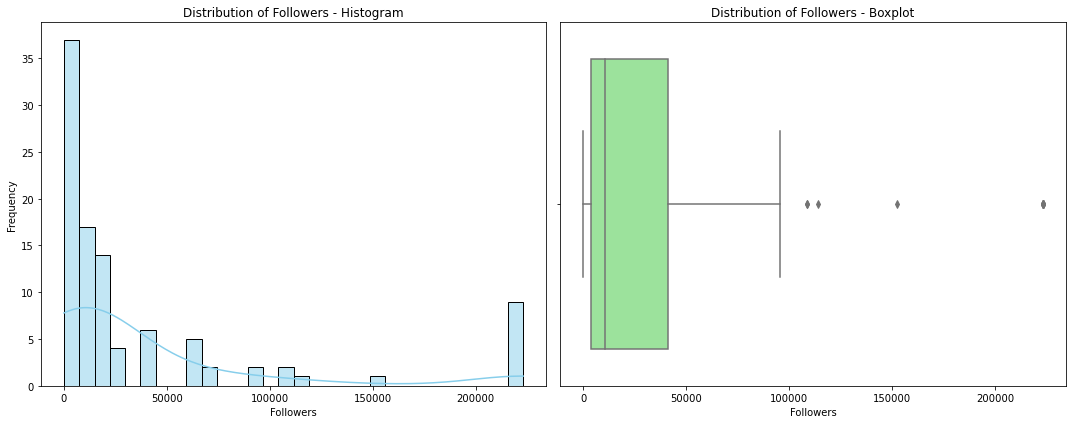

In [17]:
# Plotting the distribution of followers
plt.figure(figsize=(15, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(quotes_df['Followers'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Followers - Histogram')
plt.xlabel('Followers')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(quotes_df['Followers'], color='lightgreen')
plt.title('Distribution of Followers - Boxplot')
plt.xlabel('Followers')

plt.tight_layout()
plt.show()

#### Analyze and Boxplot
The histogram and boxplot provide a dual perspective on the distribution of followers for the authors in the dataset.

The histogram reveals the frequency of authors with certain ranges of followers, showing a right-skewed distribution. This indicates that most authors have a relatively low number of followers, with fewer authors having very high follower counts.

The boxplot complements this by displaying the range of followers through quartiles, highlighting the presence of outliers with significantly high follower counts. The concentration of data points at the lower end of the scale suggests a competitive environment where a small number of authors have a large following, while the majority have fewer followers.

This pattern of distribution is important for our research question because it suggests that only a few authors manage to stand out in terms of popularity. Whether this is related to the use of specific tag combinations is what we need to analyze next.

We will now investigate the relationship between tag combinations and the number of followers by visualizing the distribution of author followers by tag combinations. This will be the final step to draw insights for our research question.​

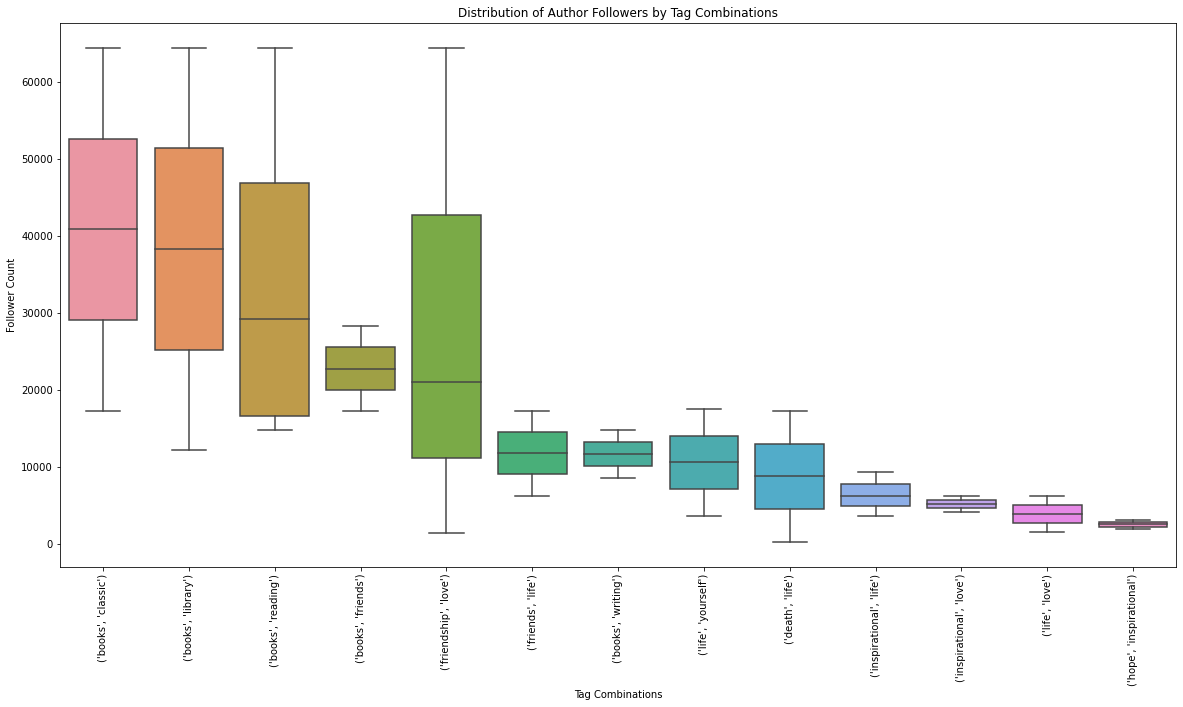

In [18]:
# Convert 'Tags' to lists if they are in string format
quotes_df['Tags'] = quotes_df['Tags'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Count tag combinations and filter by frequency
tag_combinations = Counter(
    combo for tags in quotes_df['Tags'] for combo in combinations(tags, 2)
)
filtered_combinations = {k: v for k, v in tag_combinations.items() if v > 1}

# Create a new DataFrame column for filtered tag combinations and explode
quotes_df['Filtered Tag Combinations'] = quotes_df['Tags'].apply(
    lambda tags: [combo for combo in combinations(tags, 2) if filtered_combinations.get(combo, 0) > 1]
)
exploded_df = quotes_df.explode('Filtered Tag Combinations').dropna(subset=['Filtered Tag Combinations'])

# Convert 'Followers' to integers
exploded_df['Followers'] = exploded_df['Followers'].astype(int)

# Plotting
plt.figure(figsize=(20, 10))
sns.boxplot(
    data=exploded_df,
    x='Filtered Tag Combinations',
    y='Followers',
    order=exploded_df.groupby('Filtered Tag Combinations')['Followers'].median().sort_values(ascending=False).index
)
plt.xticks(rotation=90)  # Rotate the x-axis labels for readability
plt.xlabel('Tag Combinations')
plt.ylabel('Follower Count')
plt.title('Distribution of Author Followers by Tag Combinations')
plt.show()


#### Discussions and Concousion
From the visualizations and the data analysis, we observe that:

**·** Certain tags appear much more frequently than others, suggesting popular themes such as "love," "inspirational," and "life."

**·** Some tag combinations occur together more often, like "books" and "reading" or "inspirational" and "life," indicating thematic overlaps that could resonate more with readers.

**·** The distribution of tag counts in quotes shows that a variety of tags are used, with a higher frequency of quotes containing fewer tags.

**·** The distribution of followers is highly skewed, with most authors having a small number of followers and a few authors having a very high number of followers.

**·** The boxplot of follower counts by tag combinations indicates that certain combinations correlate with higher median follower counts, suggesting a potential influence of tag synergy on author popularity.

### Conclusion
In conclusion, our analysis supports the hypothesis that certain tag combinations are more prevalent and possibly more influential in accruing followers for authors. Tags related to universally resonant themes tend to cluster together and are associated with authors who have higher follower counts. This suggests that authors who can tap into these thematic currents and utilize popular tag combinations may enhance their visibility and appeal to a broader audience.

However, the variability and presence of outliers suggest that while tags can play a role in building an author's following, they are likely just one factor among many in the complex dynamics of social media popularity.